# Regularized Regression

Easy, fast linear regression with L2 regularization!

## Imports & stuff

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import celerite
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from ipywidgets import Layout
import pandas as pd

In [3]:
!wget https://users.flatironinstitute.org/rluger/public_www/LSST-DSFP/problem1.csv
!wget https://users.flatironinstitute.org/rluger/public_www/LSST-DSFP/problem2.csv

--2019-09-12 13:32:20--  https://users.flatironinstitute.org/rluger/public_www/LSST-DSFP/problem1.csv
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 104.25.229.37, 104.25.230.37
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|104.25.229.37|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~rluger/LSST-DSFP/problem1.csv [following]
--2019-09-12 13:32:21--  https://users.flatironinstitute.org/~rluger/LSST-DSFP/problem1.csv
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 5326480 (5.1M) [application/octet-stream]
Saving to: ‘problem1.csv’

problem1.csv        100%[===================>]   5.08M  5.75MB/s    in 0.9s    

2019-09-12 13:32:22 (5.75 MB/s) - ‘problem1.csv’ saved [5326480/5326480]

--2019-09-12 13:32:22--  https://users.flatironinstitute.org/rluger/public_www/LSST-DSFP/problem2.csv
Resol

## Problem -1: Fitting a polynomial

Let's generate some synthetic data with a small trend and lots of noise.

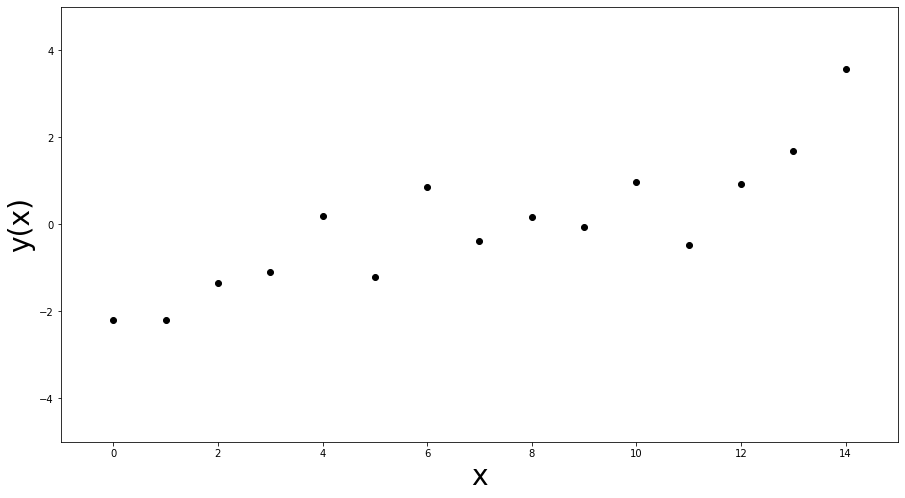

In [4]:
npts = 15
np.random.seed(1)
x = np.arange(npts, dtype="float64")
y = 0.5 * np.random.randn(npts) + 3 * np.linspace(-1, 1, npts) ** 3

fig, ax = plt.subplots(1, figsize=(15, 8))
ax.plot(x, y, 'ko')
ax.set_xlabel("x", fontsize=28)
ax.set_ylabel("y(x)", fontsize=28)
ax.set_xlim(-1, npts)
ax.set_ylim(-5, 5);

Let's fit it with a polynomial with no regularization. We'll set up a slider to increase the order of the polynomial from 0 to the total number of data points.

In [5]:
# Define our controls
slider = widgets.IntSlider(value=0, min=0, max=npts - 1, step=1,
            disabled=False, continuous_update=False, orientation='horizontal',
            readout=True, layout=Layout(width='100%'))
play = widgets.Play(
    interval=1000,
    value=0,
    min=0,
    max=30,
    step=1,
    description="Press play",
    disabled=False
)
widgets.jslink((play, 'value'), (slider, 'value'))
control = widgets.HBox([play, slider])

def visualize_func(N=0):
    # Normalize `x` to prevent numerical instabilities
    t = (x - x[0]) / (x[-1] - x[0]) - 0.5
    
    # Compute the weights
    A = np.vander(t, N + 1, increasing=True)
    C = A.T.dot(A)
    w = np.linalg.solve(C, A.T.dot(y))
    
    # Compute the model at hi res
    x_ = np.linspace(-1, npts, 300)
    t_ = (x_ - x[0]) / (x[-1] - x[0]) - 0.5
    A_ = np.vander(t_, N + 1, increasing=True)
    model_ = A_.dot(w)
    
    # Plot it!
    fig, ax = plt.subplots(1, figsize=(15, 8))
    ax.plot(x, y, 'ko')
    ax.plot(x_, model_)
    ax.set_xlabel("x", fontsize=28)
    ax.set_ylabel("y(x)", fontsize=28)
    ax.set_xlim(-1, npts)
    ax.set_ylim(-5, 5)
    ax.set_title("Polynomial order: %d" % N, fontsize=28)

plot = interactive_output(visualize_func, {"N": slider})

# Display!
display(plot)
display(control)

Output()

HBox(children=(Play(value=0, description='Press play', interval=1000, max=30), IntSlider(value=0, continuous_update=False, layout=Layout(width='100%'), max=14)))

High order polynomials fit the data "perfectly", but that's usually not what we want, since they have no predictive power!

## Problem 0: Fitting a polynomial with L2 regularization

Now let's add some regularization. We'll add a new slider whose value is the log of the prior variance on the polynomial coefficients. Large values mean very weak regularization; small values mean very strong regularization.

In [6]:
# Define our controls
slider = widgets.IntSlider(value=0, min=0, max=npts - 1, step=1,
            disabled=False, continuous_update=False, orientation='horizontal',
            readout=True, layout=Layout(width='100%'))

l_slider = widgets.FloatSlider(value=20, min=-3, max=20, step=0.1,
            disabled=False, continuous_update=False, orientation='horizontal',
            readout=True, layout=Layout(width='100%'), description="Log variance")

play = widgets.Play(
    interval=1000,
    value=0,
    min=0,
    max=30,
    step=1,
    description="Press play",
    disabled=False
)
widgets.jslink((play, 'value'), (slider, 'value'))
control = widgets.HBox([play, slider])

def visualize_func(N=0, log_lam=0):
    # Normalize `x` to prevent numerical instabilities
    t = (x - x[0]) / (x[-1] - x[0]) - 0.5
    
    # Compute the weights
    A = np.vander(t, N + 1, increasing=True)
    C = A.T.dot(A)
    C[np.diag_indices_from(C)] += 1.0 / 10 ** log_lam
    w = np.linalg.solve(C, A.T.dot(y))
    
    # Compute the model at hi res
    x_ = np.linspace(-1, npts, 300)
    t_ = (x_ - x[0]) / (x[-1] - x[0]) - 0.5
    A_ = np.vander(t_, N + 1, increasing=True)
    model_ = A_.dot(w)
    
    # Plot it!
    fig, ax = plt.subplots(1, figsize=(15, 8))
    ax.plot(x, y, 'ko')
    ax.plot(x_, model_)
    ax.set_xlabel("x", fontsize=28)
    ax.set_ylabel("y(x)", fontsize=28)
    ax.set_xlim(-1, npts)
    ax.set_ylim(-5, 5)
    ax.set_title("Polynomial order: %d" % N, fontsize=28)

plot = interactive_output(visualize_func, {"N": slider, "log_lam": l_slider})

# Display!
display(plot)
display(control)
display(l_slider)

Output()

HBox(children=(Play(value=0, description='Press play', interval=1000, max=30), IntSlider(value=0, continuous_update=False, layout=Layout(width='100%'), max=14)))

FloatSlider(value=20.0, continuous_update=False, description='Log variance', layout=Layout(width='100%'), max=20.0, min=-3.0)

## Problem 1: Find the transit!

Below is a light curve of a star collected with a certain telescope. We suspect that there is an exoplanet transit hiding somewhere in the dataset, but unfortunately the light curve is dominated by instrument systematics.

Your task is to find the transit and report the approximate time of transit and transit depth (in ppm).

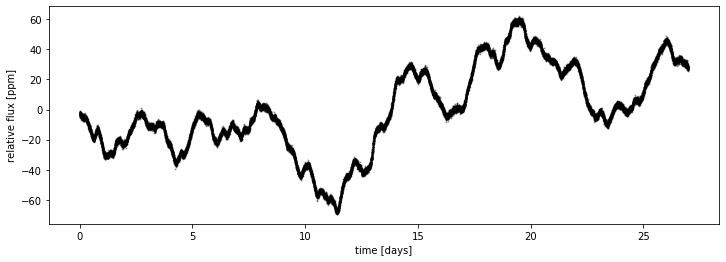

In [12]:
# Load the data
df = pd.read_csv("problem1.csv")
t = np.array(df["time"])
flux = np.array(df["flux"])
flux_err = np.mean(np.array(df["flux_err"]))

# Plot it
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=2)
ax.set_ylabel("relative flux [ppm]")
ax.set_xlabel("time [days]");

There are lots of features that look transit-like! Normally we'd be at a loss, but fortunately we have access to a few telescope housekeeping variables that we suspect correlate with the systematics component of the light curve. Let's take a look at the data frame:

In [9]:
df.head()

,time,flux,flux_err,temperature,cloudiness,psf_stability,humidity,air_pressure
0,0.000000,-3.733752,1.0,4.254513,-4.019605,-1.160100,-6.360637,-1.496569
1,0.000694,-1.658680,1.0,4.247355,-4.014178,-1.162467,-6.359643,-1.497345
2,0.001389,-1.579171,1.0,4.240592,-4.009298,-1.164907,-6.358750,-1.497830
3,0.002083,-2.322379,1.0,4.233681,-4.004617,-1.167572,-6.357873,-1.498096
4,0.002778,-1.530432,1.0,4.226457,-3.999685,-1.170057,-6.356870,-1.498100


We can construct a **design matrix** out of these housekeeping variables as follows:

In [13]:
# Construct the design matrix
A = np.hstack((np.array(df["temperature"]).reshape(-1, 1),
               np.array(df["cloudiness"]).reshape(-1, 1),
               np.array(df["psf_stability"]).reshape(-1, 1),
               np.array(df["humidity"]).reshape(-1, 1),
               np.array(df["air_pressure"]).reshape(-1, 1)))

Here's what each of the components looks like:

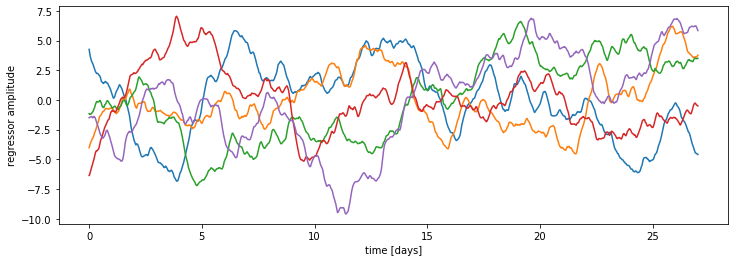

In [14]:
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, A)
ax.set_ylabel("regressor amplitude")
ax.set_xlabel("time [days]");

Perform a simple linear regression (don't worry about regularization) using this design matrix to construct your best fit model of the light curve systematics. Then have a look at the residuals: can you see the transit?

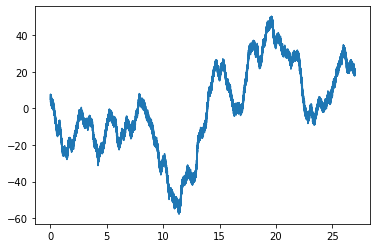

In [21]:
noise = np.sum(A, axis = 1)
plt.plot(t, flux - noise)

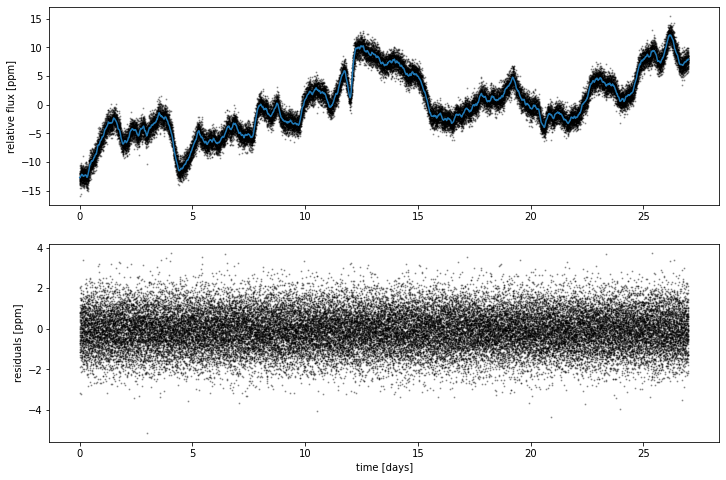

In [24]:
# Least squares fit
w = np.linalg.solve(A.T.dot(A), A.T.dot(flux))
model = A.dot(w)

# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, flux, 'k.', alpha=0.3, ms=2);
ax[0].plot(t, model)
ax[0].set_ylabel("relative flux [ppm]")
ax[1].plot(t, flux - model, 'k.', alpha=0.3, ms=2)
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("residuals [ppm]");

## Problem 2: Find the transit (again)!
This problem is similar to **Problem 1**, except now we have **many** housekeeping variables that we think might correlate with the systematics model. Again, we have a transit hiding somewhere in the light curve, and we'll de-trend the dataset using the housekeeping variable to attempt to find the transit.

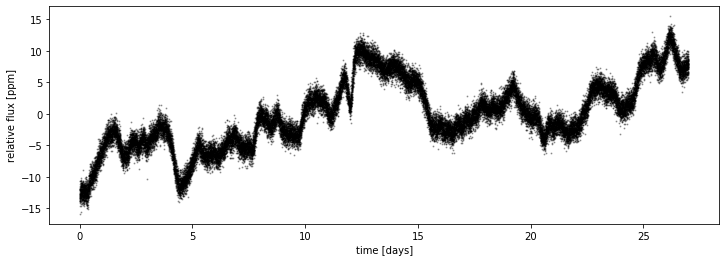

In [22]:
# Load the data
nreg = 500
df = pd.read_csv("problem2.csv")
t = np.array(df["time"])
flux = np.array(df["flux"])
flux_err = np.mean(np.array(df["flux_err"]))
A = np.hstack([np.array(df["A%03d" % n]).reshape(-1, 1) for n in range(nreg)])

# Plot it
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=2)
ax.set_ylabel("relative flux [ppm]")
ax.set_xlabel("time [days]");

**A.** First, perform a simple linear least-squares fit with no regularization to de-trend the light curve, and inspect the residuals. Do you see the transit? What happened?

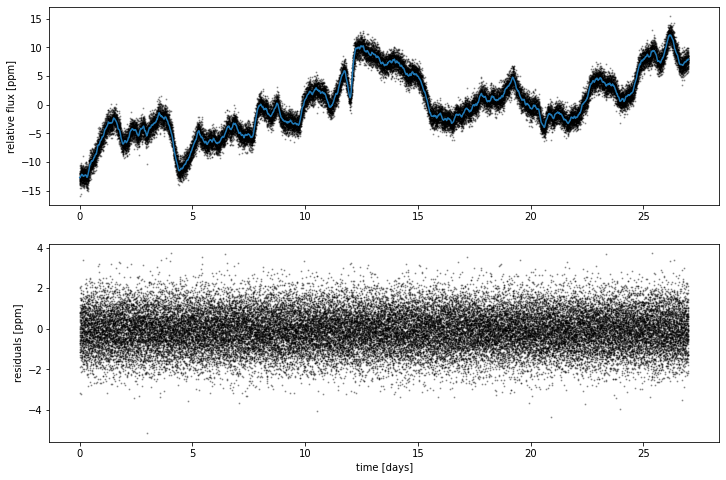

In [25]:
# Least squares fit
w = np.linalg.solve(A.T.dot(A), A.T.dot(flux))
model = A.dot(w)

# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, flux, 'k.', alpha=0.3, ms=2);
ax[0].plot(t, model)
ax[0].set_ylabel("relative flux [ppm]")
ax[1].plot(t, flux - model, 'k.', alpha=0.3, ms=2)
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("residuals [ppm]");

**B.** Now do the same thing, but add an L2 regularization term. You'll probably have to experiment with different values of the prior variance. Hint: try some values between $10^{-8}$ and $10^{-2}$. Can you find the transit now? What happens if the regularization is too strong? Too weak?

In [34]:
# Define our controls
slider = widgets.IntSlider(value=0, min=0, max=npts - 1, step=1,
            disabled=False, continuous_update=False, orientation='horizontal',
            readout=True, layout=Layout(width='100%'))

l_slider = widgets.FloatSlider(value=20, min=-1e-8, max=1e-2, step=0.1,
            disabled=False, continuous_update=False, orientation='horizontal',
            readout=True, layout=Layout(width='100%'), description="Log variance")

play = widgets.Play(
    interval=1000,
    value=0,
    min=0,
    max=30,
    step=1,
    description="Press play",
    disabled=False
)
widgets.jslink((play, 'value'), (slider, 'value'))
control = widgets.HBox([play, slider])

def visualize_func(N=0, log_lam=0):
    # Normalize `x` to prevent numerical instabilities
    t1 = (t - t[0]) / (t[-1] - t[0]) - 0.5
    
    # Compute the weights
    A = np.vander(t1, N + 1, increasing=True)
    C = A.T.dot(A)
    C[np.diag_indices_from(C)] += 1.0 / 10 ** log_lam
    #w = np.linalg.solve(C, A.T.dot(flux))
    
    lam = 1e-5
    w = np.linalg.solve(A.T.dot(A) / flux_err ** 2 + 1.0 / lam * np.diag(np.ones(nreg)), A.T.dot(flux) / flux_err ** 2)
    #model = A.dot(w)
    
    # Compute the model at hi res
    t_ = np.linspace(-1, npts, 300)
    t1_ = (t_ - t[0]) / (t[-1] - t[0]) - 0.5
    A_ = np.vander(t1_, N + 1, increasing=True)
    model_ = A_.dot(w)
    
    # Plot it!
    fig, ax = plt.subplots(1, figsize=(15, 8))
    ax.plot(t, flux, 'k.')
    ax.plot(t_, model_)
    ax.set_xlabel("t", fontsize=28)
    ax.set_ylabel("flux(t)", fontsize=28)
    #ax.set_xlim(-1, npts)
    #ax.set_ylim(-15, 15)
    ax.set_title("Polynomial order: %d" % N, fontsize=28)

plot = interactive_output(visualize_func, {"N": slider, "log_lam": l_slider})

# Display!
display(plot)
display(control)
display(l_slider)

Output()

HBox(children=(Play(value=0, description='Press play', interval=1000, max=30), IntSlider(value=0, continuous_update=False, layout=Layout(width='100%'), max=14)))

FloatSlider(value=0.01, continuous_update=False, description='Log variance', layout=Layout(width='100%'), max=0.01, min=-1e-08)

## Problem 3: Model the transit

One of the classic problems with de-trending is that quite often we throw the baby out with the bathwater. When removing the systematics like we did above, we almost always end up removing a bit of the signal we actually care about.

One way around this is to **simultaneously** fit the systematics model and the transit model.

Suppose for simplicity that we know the time of the transit and the shape of the transit exactly, but we do not know the depth. Here's the functional form of the transit model:

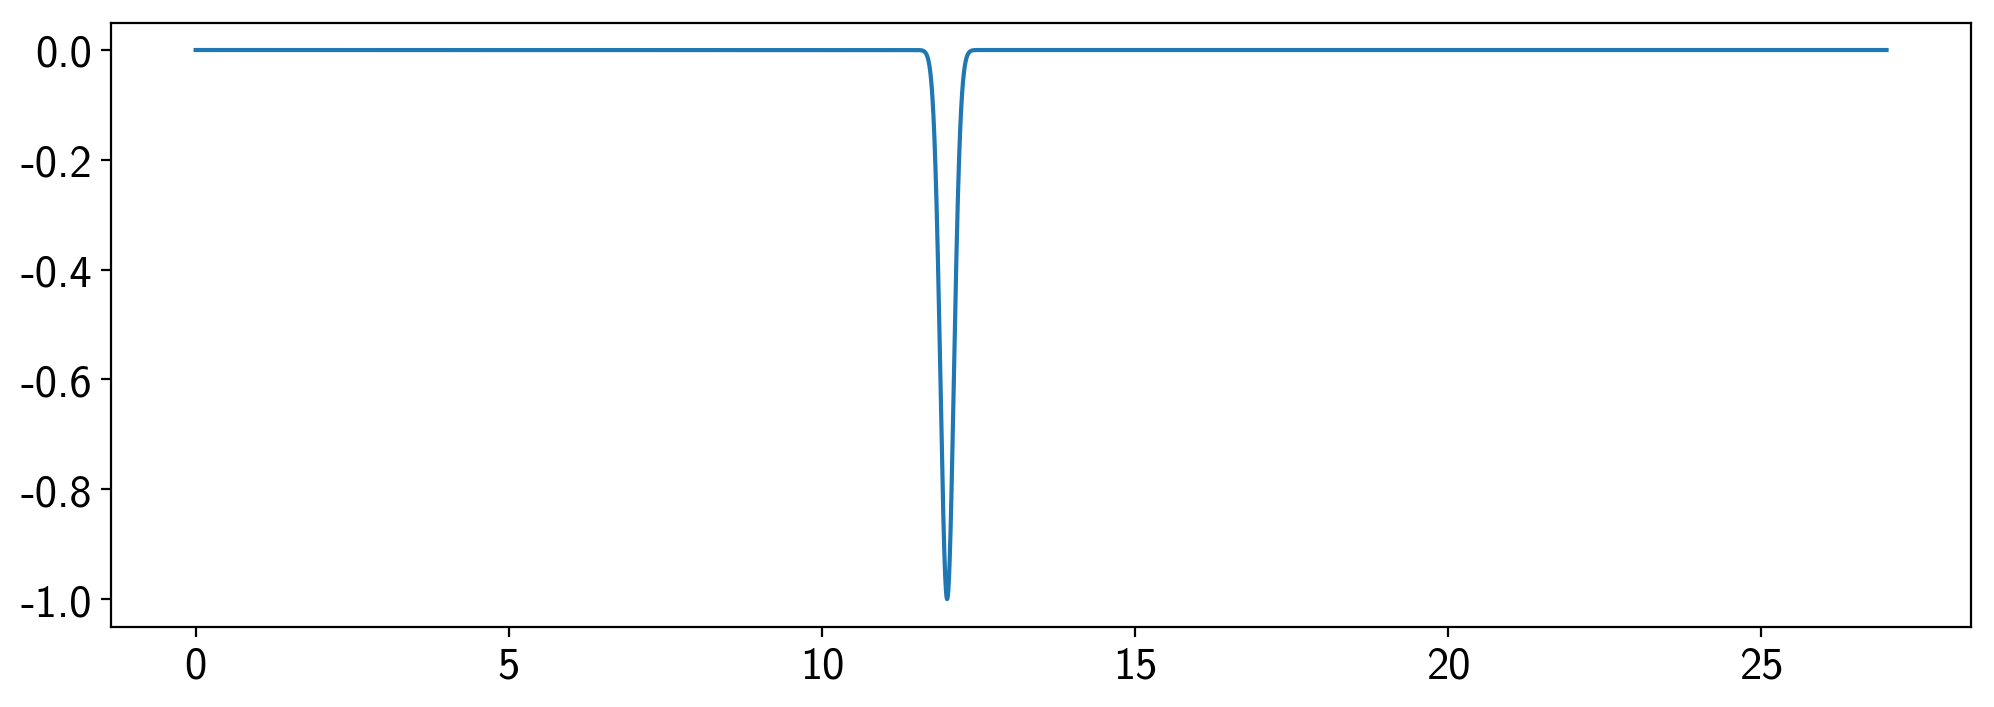

In [12]:
t0 = 12.0
sig_t = 0.15
transit_model = -np.exp(-(t - t0) ** 2 / sig_t ** 2)
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, transit_model);

Add this transit model as a column in your design matrix, and re-do the regression, remembering to add an entry to your L2 prior corresponding to the prior variance on the transit. You can assume a variance of **infinity** for the transit depth (what kind of prior does this correspond to?).

Once that's done, plot the data minus the systematics component of the model, and compare to the results of **Problem 2.** Overplot the inferred transit model, and report the recovered depth and its uncertainty.